# DE School on PhotoZ in 2016 (Oxford)

In [2]:
%matplotlib inline
from __future__ import division #avoids integer division; 1/2 = 0.5, not 0 
import numpy as np #numpy routines
from astropy.table import Table   #astropy routine for reading tables
import matplotlib.pyplot as plt   #plotting routines

# Random forest routine from scikit-learn:
from sklearn.ensemble import RandomForestRegressor

# Cross-Validation routines:
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import cross_val_predict
from sklearn.model_selection import cross_val_predict

In [3]:
#read in catalog of magnitudes and redshifts
cat = Table.read('data_trim.fits.gz')

# How big is the catalog?
print('Full catalog: ',len(cat),' objects')

# What information does it contain for each object?
print(cat.colnames)
print(cat)

Full catalog:  8508  objects
['U', 'G', 'R', 'I', 'Z', 'Y', 'UERR', 'GERR', 'RERR', 'IERR', 'ZERR', 'YERR', 'RADIUS_ARCSEC', 'ZHELIO', 'MAGB', 'UB_0']
        U                  G                  R          ...    MAGB    UB_0 
------------------ ------------------ ------------------ ... --------- ------
24.406259822981863  24.15491649674258  23.48145527142695 ... 24.382738 0.7524
23.596622644924793 23.438932812223943 23.002113529819155 ... 23.252705 0.5318
 24.02840020822941 24.123041106148666  23.45268078980818 ...  23.97421 0.3947
 24.70997974248575 24.426899989123946 23.535199171213332 ... 24.181963 0.6457
23.562624256983202  22.76517494822343  21.56296318760089 ... 23.104582 0.8135
22.800614816783543 21.934401465857267  21.38487088619466 ... 22.013208  0.563
25.874493585228752  23.95672107559005 22.372583862542434 ... 25.291895 1.2528
  23.2448841203016 23.029178146787224 22.420172524493985 ... 22.885334 0.4168
24.039279476756526 23.977530397544953  24.06007476440935 ... 24.10030

In [4]:
cat

U,G,R,I,Z,Y,UERR,GERR,RERR,IERR,ZERR,YERR,RADIUS_ARCSEC,ZHELIO,MAGB,UB_0
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32
24.406259822981863,24.15491649674258,23.48145527142695,22.76817543243521,22.30459708983353,22.08804838039685,0.10019999742507935,0.061500001698732376,0.041999999433755875,0.04729999974370003,0.05079999938607216,0.03325571492314339,0.5956838665008545,0.9576695,24.382738,0.7524
23.596622644924793,23.438932812223943,23.002113529819155,22.54181763626589,22.262656988194113,21.845465073123282,0.06030000001192093,0.04010000079870224,0.03290000185370445,0.0471000000834465,0.05739999935030937,0.04351166635751724,0.7713657388687134,0.9090429,23.252705,0.5318
24.02840020822941,24.123041106148666,23.45268078980818,23.350731306816215,22.915108914340106,22.67626471306376,0.061500001698732376,0.0502999983727932,0.04699999839067459,0.07320000231266022,0.08060000091791153,0.06776599586009979,0.5430184621810913,0.50297445,23.97421,0.3947
24.70997974248575,24.426899989123946,23.535199171213332,23.14611238178327,22.691381386819433,22.880028703460603,0.16940000653266907,0.09950000047683716,0.05130000039935112,0.07880000025033951,0.09870000183582306,0.09527058899402618,0.7498138303756714,0.6498387,24.181963,0.6457
23.562624256983202,22.76517494822343,21.56296318760089,20.636332420014245,20.41397449733501,20.292652834203444,0.05389999970793724,0.018699999898672104,0.007699999958276749,0.007600000128149986,0.010200000368058681,0.009047791361808777,0.6260172300338745,0.6794403,23.104582,0.8135
22.800614816783543,21.934401465857267,21.38487088619466,21.140233993670925,21.03738328477425,20.81493506074778,0.026900000870227814,0.00839999970048666,0.009700000286102295,0.010499999858438969,0.017500000074505806,0.015279552899301052,0.6833134946823121,0.07407781,22.013208,0.563
25.874493585228752,23.95672107559005,22.372583862542434,21.18201228980095,20.727986554034526,20.436827416238312,0.5102999806404114,0.06989999860525131,0.01889999955892563,0.014399999752640724,0.018400000408291817,0.011033563874661922,0.8027191457748413,0.68388146,25.291895,1.2528
23.2448841203016,23.029178146787224,22.420172524493985,22.023390139985775,21.817108500363414,21.67924141792397,0.04280000180006027,0.024299999698996544,0.016699999570846558,0.02630000002682209,0.03449999913573265,0.02857847325503826,0.665982424736023,0.65113693,22.885334,0.4168
24.039279476756526,23.977530397544953,24.06007476440935,23.557311713510497,23.487268748497648,23.543366546358584,0.06759999692440033,0.04820000007748604,0.06159999966621399,0.08940000087022781,0.15070000290870667,0.12286899983882904,0.5099770746231079,1.0579633,24.100306,0.4601


In [5]:
#A function that we will call a lot: makes the zphot/zspec plot and calculates key statistics
def plot_and_stats(zspec,zphot):
    
    x = np.arange(0,5.4,0.05)
    outlier_upper = x + 0.15*(1+x)
    outlier_lower = x - 0.15*(1+x)

    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15
    notmask = ~mask 
    
        #Standard Deviation of the predicted redshifts compared to the data:
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)

    #Normalized MAD (Median Absolute Deviation):
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    #Percentage of delta-z > 0.15(1+z) outliers:
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    #Median offset (normalized by (1+z); i.e., bias:
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    # make photo-z/spec-z plot
    plt.figure(figsize=(8, 8))
    
    #add lines to indicate outliers
    plt.plot(x, outlier_upper, 'k--')
    plt.plot(x, outlier_lower, 'k--')
    plt.plot(z_spec[mask], z_phot[mask], 'r.', markersize=6,  alpha=0.5)
    plt.plot(z_spec[notmask], z_phot[notmask], 'b.',  markersize=6, alpha=0.5)
    plt.plot(x, x, linewidth=1.5, color = 'red')
    plt.title('$\sigma_\mathrm{NMAD} \ = $%6.4f\n'%nmad+'$(\Delta z)>0.15(1+z) $ outliers = %6.3f'%(eta*100)+'%', fontsize=18)
    plt.xlim([0.0, 2])
    plt.ylim([0.0, 2])
    plt.xlabel('$z_{\mathrm{spec}}$', fontsize = 27)
    plt.ylabel('$z_{\mathrm{photo}}$', fontsize = 27)
    plt.grid(alpha = 0.8)
    plt.tick_params(labelsize=15)
    plt.show()
    

In [6]:
# create convenience arrays for all magnitudes
u_mag = cat['U']
g_mag = cat['G']
r_mag = cat['R']
i_mag = cat['I']
z_mag = cat['Z']
y_mag = cat['Y']

# and for magnitude errors
u_err = cat['UERR']
g_err = cat['GERR']
r_err = cat['RERR']
i_err = cat['IERR']
z_err = cat['ZERR']
y_err = cat['YERR']

#Redshift array
z = cat['ZHELIO']

#Size array: radius in arcseconds
rad = cat['RADIUS_ARCSEC']

#Restframe color
ub_color = cat['UB_0']

#Photometry perturbed: doubling sizes of all errors
u_magn=u_mag + np.sqrt(3)*u_err*np.random.randn(len(u_mag))
g_magn=g_mag + np.sqrt(3)*g_err*np.random.randn(len(g_mag))
r_magn=r_mag + np.sqrt(3)*r_err*np.random.randn(len(r_mag))
i_magn=i_mag + np.sqrt(3)*i_err*np.random.randn(len(i_mag))
z_magn=z_mag + np.sqrt(3)*z_err*np.random.randn(len(z_mag))
y_magn=y_mag + np.sqrt(3)*y_err*np.random.randn(len(y_mag))


# Now, set up input data arrays for random forest regression

# First: magnitudes only
data_mags = np.column_stack((u_mag,g_mag,r_mag,i_mag,z_mag,y_mag))

# Next: colors only
data_colors = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag-z_mag, z_mag-y_mag))

# Next: colors and one magnitude
data_colmag = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag-z_mag, z_mag-y_mag, i_mag))
perturbed_colmag=np.column_stack((u_magn-g_magn, g_magn-r_magn, r_magn-i_magn, i_magn-z_magn, z_magn-y_magn, i_magn))

# Finally: colors, magnitude, and size
data_colmagsize = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag-z_mag, z_mag-y_mag, i_mag, rad))

    
data_z = z

# We need to set up an implementation of the scikit-learn RandomForestRegressor in an object called 'regrn'. 
regrn = RandomForestRegressor(n_estimators = 50, max_depth = 30, max_features = 'auto')

# Relationships of galaxy properties to magnitude

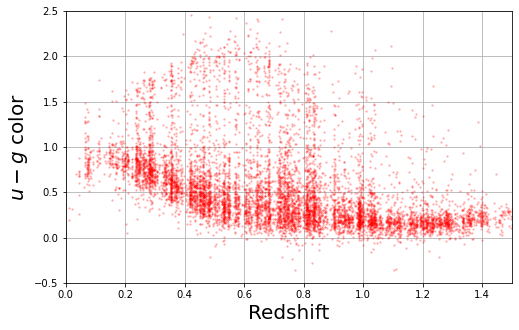

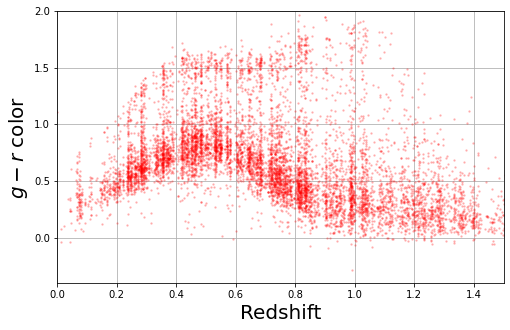

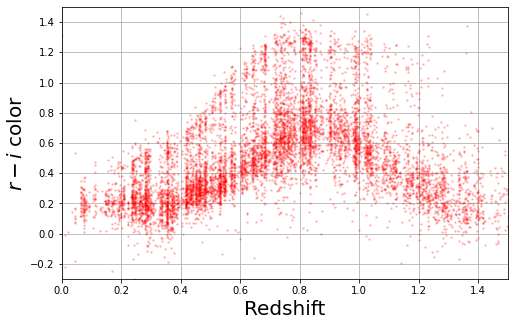

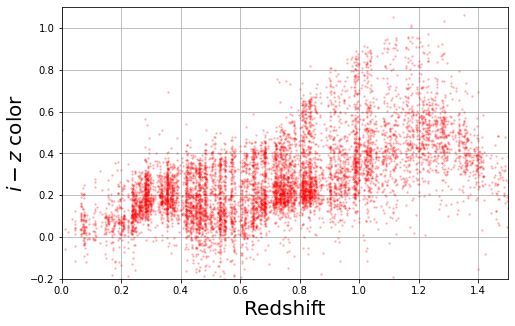

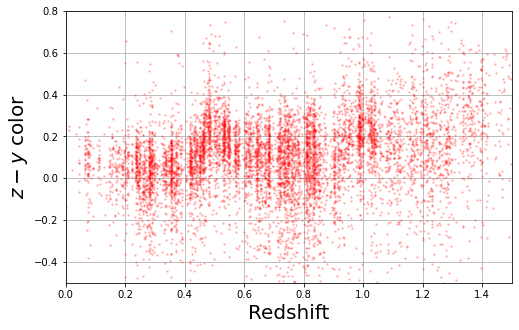

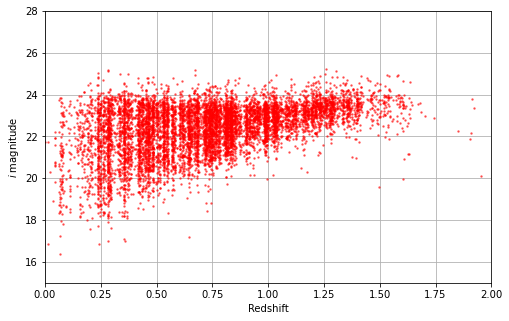

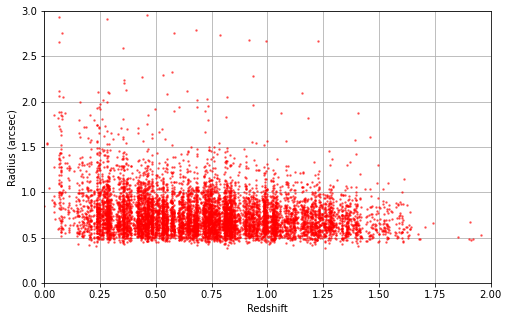

In [7]:
if 1:
# Plots of colors vs. redshift

    plt.figure(figsize=(8, 5))

    plt.plot(z, u_mag-g_mag, '.', color = 'red', markersize=3, alpha=0.2)
    # Axis limits:
    plt.xlim([0., 1.5])
    plt.ylim([-0.5, 2.5])
    #Axis labels
    plt.ylabel('$u-g$ color', fontsize=20)
    plt.xlabel('Redshift',fontsize=20)
    #Add grid lines
    plt.grid()


    plt.figure(figsize=(8, 5))

    plt.plot(z, g_mag-r_mag, '.', color = 'red', markersize=3, alpha=0.2)
    plt.xlim([0., 1.5])
    plt.ylim([-0.4, 2.])
    plt.ylabel('$g-r$ color', fontsize=20)
    plt.xlabel('Redshift',fontsize=20)
    plt.grid()


    plt.figure(figsize=(8, 5))

    plt.plot(z, r_mag-i_mag, '.', color = 'red', markersize=3, alpha=0.2)
    plt.xlim([0., 1.5])
    plt.ylim([-0.3, 1.5])
    plt.ylabel('$r-i$ color', fontsize=20)
    plt.xlabel('Redshift',fontsize=20)
    plt.grid()


    plt.figure(figsize=(8, 5))

    plt.plot(z, i_mag-z_mag, '.', color = 'red', markersize=3, alpha=0.2)
    plt.xlim([0., 1.5])
    plt.ylim([-0.2, 1.1])
    plt.ylabel('$i-z$ color', fontsize=20)
    plt.xlabel('Redshift',fontsize=20)
    plt.grid()

    plt.figure(figsize=(8, 5))

    plt.plot(z, z_mag-y_mag, '.', color = 'red', markersize=3, alpha=0.2)
    plt.xlim([0., 1.5])
    plt.ylim([-0.5, 0.8])
    plt.ylabel('$z-y$ color', fontsize=20)
    plt.xlabel('Redshift',fontsize=20)
    plt.grid()

    plt.figure(figsize=(8, 5))

    #Plot of i magnitude vs. size
    plt.plot(z, i_mag, '.', color = 'red', markersize=3, alpha=0.5)
    plt.xlim([0., 2.])
    plt.ylim([15.0, 28])
    plt.ylabel('$i$ magnitude')
    plt.xlabel('Redshift')
    plt.grid()

# Plot of radius vs. size
    plt.figure(figsize=(8, 5))

    plt.plot(z, rad, '.', color = 'red', markersize=3, alpha=0.5)
    # Axis limits:
    plt.xlim([0., 2.])
    plt.ylim([0, 3])
    plt.ylabel('Radius (arcsec)')
    plt.xlabel('Redshift')
    plt.grid()



# Running photo-z code and testing the results

## Random forest - 50/50 training/test split

To start, we'll split our data in two randomly, train with 50%, and test with the other 50%.

Standard Deviation: 0.0854
Normalized MAD: 0.0425
Delta z >0.15(1+z) outliers:  6.112 percent
Median offset:  0.004 +/-  0.002


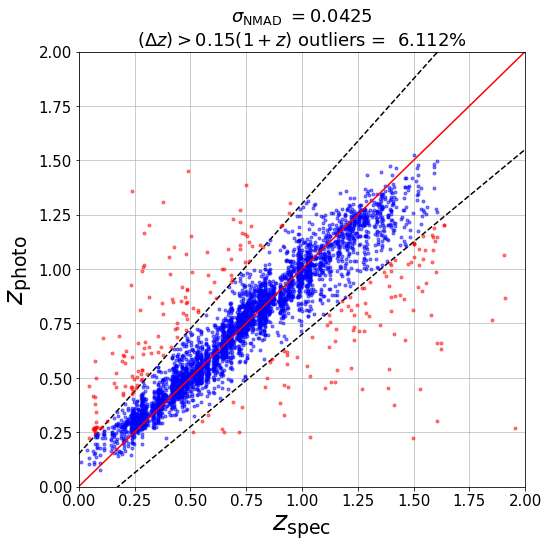

In [8]:
if 1:

    # To better assess the quality of the Random Forest fitting, 
    # we split the data into Training (50%) and Test (50%) sets. 
    # The code below performs this task on the data_mags and data_z arrays:
    data_train, data_test, z_train, z_test = train_test_split(data_mags, data_z, 
                        test_size = 0.50, train_size = 0.50, random_state=7182016)

    #Train the regressor using the training data
    regrn.fit(data_train,z_train)

    #Apply the regressor to predict values for the test data
    z_phot = regrn.predict(data_test)
    z_spec = z_test

    #Make a photo-z/spec-z plot and output summary statistics.
    plot_and_stats(z_spec,z_phot)

## Beware: Do not test with the same objects you use to train an algorithm !!!

Let's try it to see why not...

Standard Deviation: 0.0339
Normalized MAD: 0.0162
Delta z >0.15(1+z) outliers:  0.893 percent
Median offset:  0.002 +/-  0.001


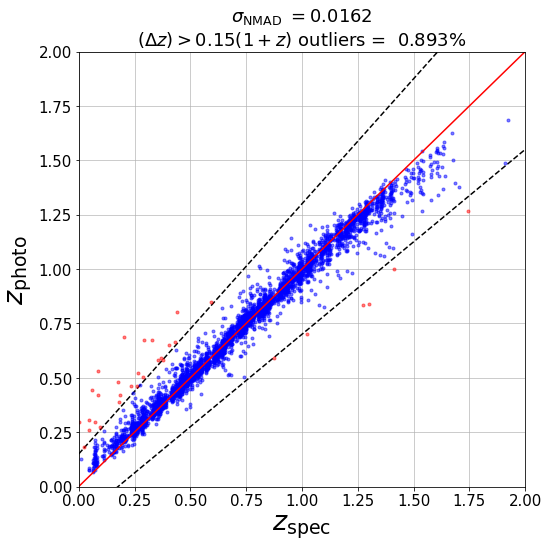

In [9]:
if 1:

    # use the regressor trained on the training set, but apply it to the training set instead of the test set
    z_phot = regrn.predict(data_train)
    z_spec = z_train

    plot_and_stats(z_spec,z_phot)

## Note: a better, but slower, way to test: k-fold Cross-validation

In k-fold cross-validation, we split the data into k subsets.  We loop over the subsets, training with all but one and testing with the other; in the end, we get the performance of training with a fraction $k-1 \over k$ of the data, but are able to get test statistics based on the  $entire$ dataset.

This is easy to do in scikit-learn, but does mean running the training k times on more data than before...

Standard Deviation: 0.0867
Normalized MAD: 0.0394
Delta z >0.15(1+z) outliers:  5.418 percent
Median offset:  0.004 +/-  0.001


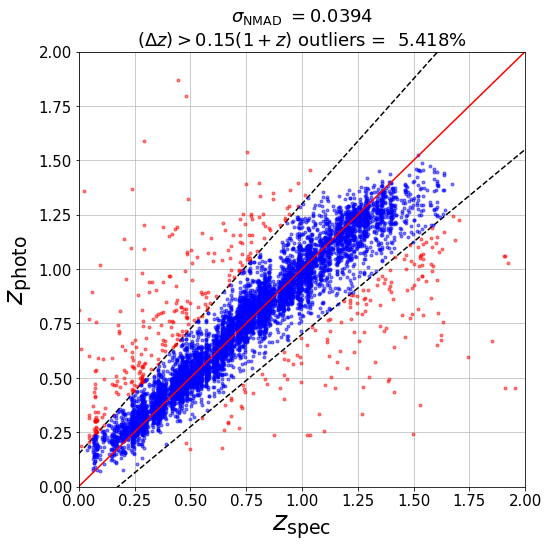

In [10]:
if 1:
    n_folds = 5

    z_phot = cross_val_predict(regrn, data_mags,data_z, cv=n_folds)
    z_spec = data_z

    plot_and_stats(z_spec,z_phot)

## Now, let's try improving our photo-z's.

First: use colors instead of raw magnitudes.

Standard Deviation: 0.0741
Normalized MAD: 0.0213
Delta z >0.15(1+z) outliers:  3.785 percent
Median offset: -0.000 +/-  0.001


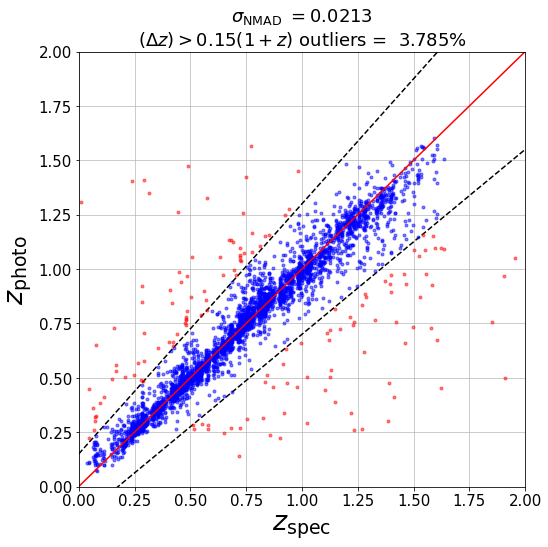

In [11]:
if 1:
    #set up the data splits
    data_train, data_test, z_train, z_test = train_test_split(data_colors, data_z, test_size = 0.50, 
                        train_size = 0.50, random_state=7182016)

    #train the regressor
    regrn.fit(data_train,z_train)

    # run on the test set
    z_phot = regrn.predict(data_test)
    z_spec = z_test

    plot_and_stats(z_spec,z_phot)

__If you're running ahead of the class, try plotting the different magnitudes versus redshift in the code box below, and see how they relate to $z$.__

## Now, let's add one magnitude.

This way, we will include all information we had in the original magnitudes, but in a form that takes more advantage of the regularities in the data.

Standard Deviation: 0.0724
Normalized MAD: 0.0216
Delta z >0.15(1+z) outliers:  3.879 percent
Median offset:  0.000 +/-  0.001


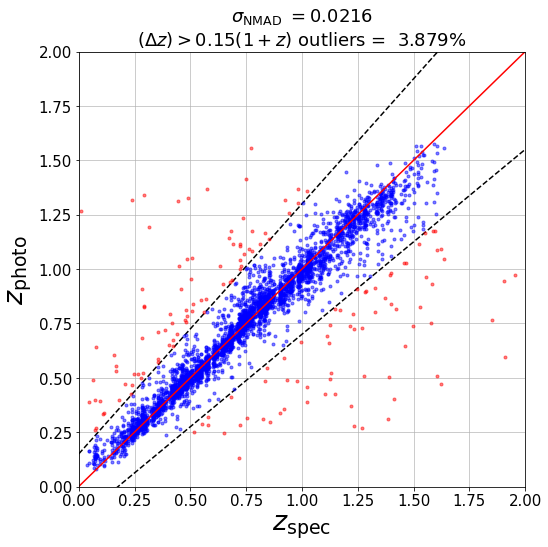

In [12]:
if 1:
    #set up the data splits
    data_train, data_test, z_train, z_test = train_test_split(data_colmag, data_z, test_size = 0.50, 
                        train_size = 0.50, random_state=7182016)

    #train the regressor
    regrn.fit(data_train,z_train)

    # run on the test set
    z_phot = regrn.predict(data_test)
    z_spec = z_test

    plot_and_stats(z_spec,z_phot)

## Does including size information help?

Let's find out!  Results in the literature are mixed. . .

Standard Deviation: 0.0731
Normalized MAD: 0.0224
Delta z >0.15(1+z) outliers:  3.879 percent
Median offset:  0.000 +/-  0.001


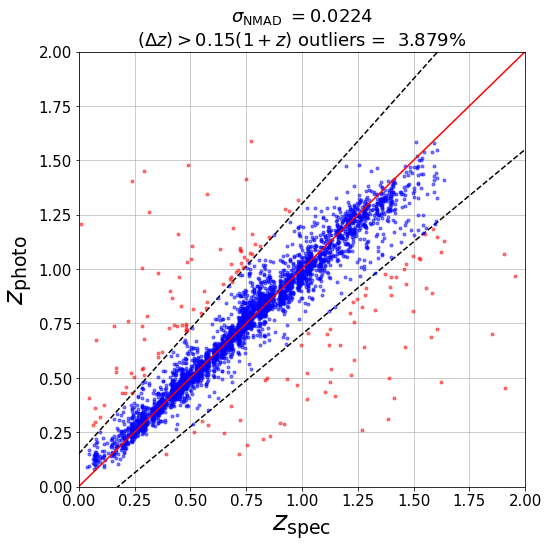

In [13]:
if 1:
    #set up the data splits
    data_train, data_test, z_train, z_test = train_test_split(data_colmagsize, data_z, test_size = 0.50, 
                        train_size = 0.50, random_state=7182016)

    #train the regressor
    regrn.fit(data_train,z_train)

    # run on the test set
    z_phot = regrn.predict(data_test)
    z_spec = z_test

    plot_and_stats(z_spec,z_phot)

## Customized photo-z's for specific galaxy populations can perform better

This can be particularly true for red sequence galaxies, which have strong spectral breaks.  Let's try to come up with  a definition of 'red' based on the restframe color distribution of galaxies:

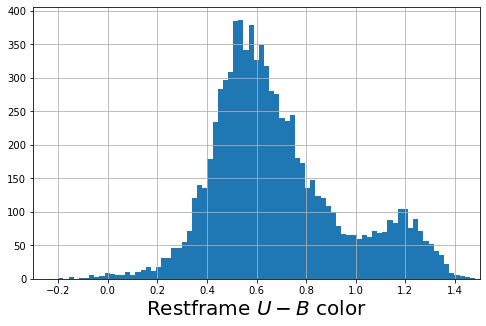

In [14]:
if 1:
    plt.figure(figsize=(8, 5))

    inrange=(ub_color > -0.5) & (ub_color < 2)
    plt.hist(ub_color[inrange],bins=100)
    # Axis limits:
    plt.xlim([-0.3, 1.5])
    plt.xlabel('Restframe $U-B$ color', fontsize=20)
    plt.grid()


Standard Deviation: 0.0368
Normalized MAD: 0.0238
Delta z >0.15(1+z) outliers:  0.637 percent
Median offset:  0.001 +/-  0.002


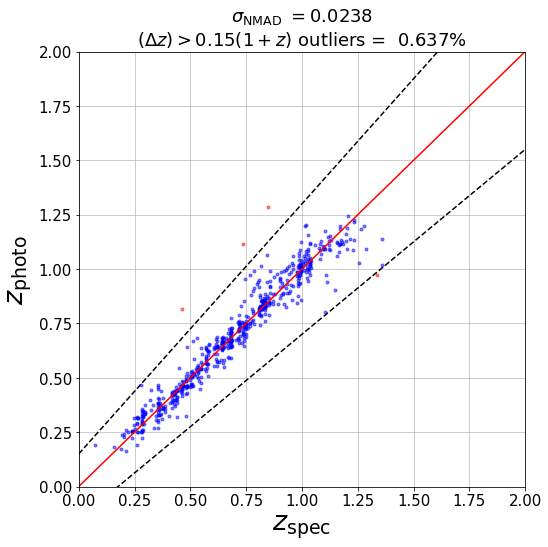

In [15]:
redlimit = 1

if 1:
    #choose only intrinsically red objects
    is_red = (ub_color > redlimit)
    
    #set up the data splits
    data_train, data_test, z_train, z_test = train_test_split(data_colmagsize[is_red], data_z[is_red], test_size = 0.50, train_size = 0.50, random_state=7182016)

    #train the regressor
    regrn.fit(data_train,z_train)

    # run on the test set
    z_phot = regrn.predict(data_test)
    z_spec = z_test

    plot_and_stats(z_spec,z_phot)

In [16]:
np.where(is_red)

(array([   6,   21,   23, ..., 8490, 8504, 8505]),)

# What happens when training and test sets differ?

## Test 1: Different magnitude ranges

Standard Deviation: 0.0899
Normalized MAD: 0.0339
Delta z >0.15(1+z) outliers:  5.398 percent
Median offset: -0.000 +/-  0.002


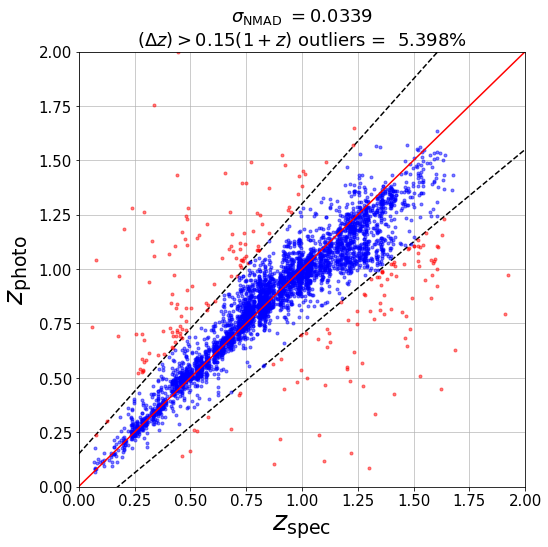

In [17]:
if 1:
    # split the sample at the median magnitude
    is_bright = r_mag < 23.15

    data_bright = data_colmag[is_bright]
    z_bright = data_z[is_bright]

    data_faint=data_colmag[~is_bright]
    z_faint = data_z[~is_bright]

    #train the regressor
    regrn.fit(data_bright,z_bright)

    # run on the test set
    z_phot = regrn.predict(data_faint)
    z_spec = z_faint

    plot_and_stats(z_spec,z_phot)

### while if we run it the opposite way...

Standard Deviation: 0.1103
Normalized MAD: 0.0295
Delta z >0.15(1+z) outliers:  9.671 percent
Median offset:  0.009 +/-  0.002


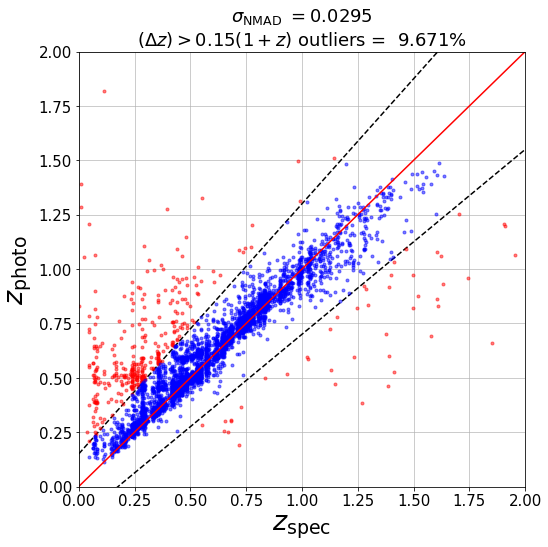

In [18]:
if 1:
    #train the regressor
    regrn.fit(data_faint,z_faint)

    # run on the test set
    z_phot = regrn.predict(data_bright)
    z_spec = z_bright

    plot_and_stats(z_spec,z_phot)

## Test 2: Different colors

Standard Deviation: 0.2032
Normalized MAD: 0.1745
Delta z >0.15(1+z) outliers: 41.415 percent
Median offset:  0.066 +/-  0.003


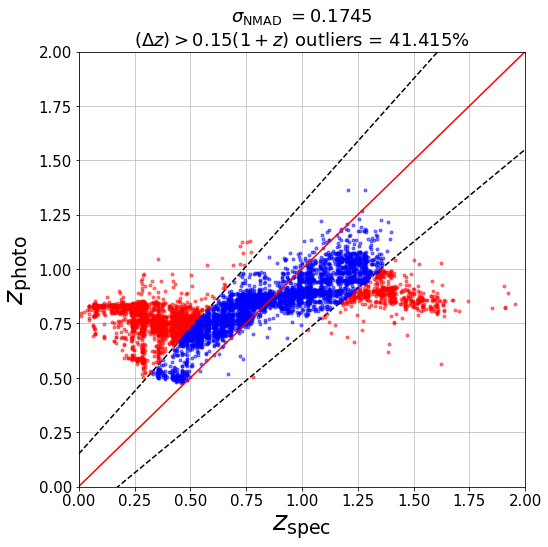

In [19]:
if 1:
    # split the sample based on r-i color
    is_red = r_mag - i_mag > 0.8

    data_red = data_colors[is_red]
    z_red = data_z[is_red]

    data_blue=data_colors[~is_red]
    z_blue = data_z[~is_red]

    #train the regressor
    regrn.fit(data_red,z_red)

    # run on the test set
    z_phot = regrn.predict(data_blue)
    z_spec = z_blue

    plot_and_stats(z_spec,z_phot)

## Test 3: Different redshift ranges

Standard Deviation: 0.1075
Normalized MAD: 0.2391
Delta z >0.15(1+z) outliers: 54.466 percent
Median offset: -0.162 +/-  0.003


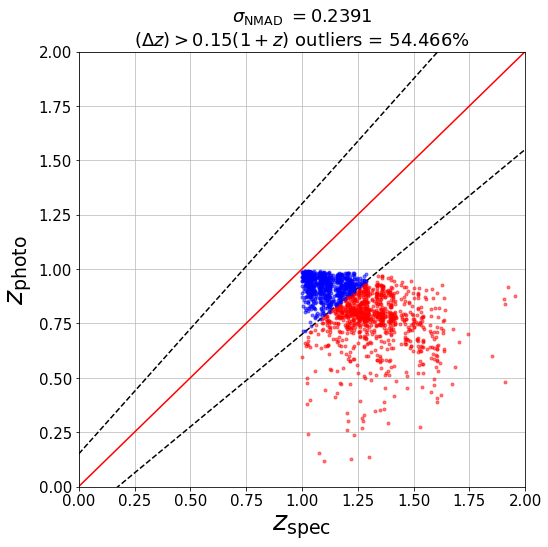

In [20]:
if 1:
    # split the sample based on redshift
    is_hiz = data_z > 1

    data_hiz = data_colors[is_hiz]
    z_hiz = data_z[is_hiz]

    data_lowz=data_colors[~is_hiz]
    z_lowz = data_z[~is_hiz]

    #train the regressor
    regrn.fit(data_lowz,z_lowz)

    # run on the test set
    z_phot = regrn.predict(data_hiz)
    z_spec = z_hiz

    plot_and_stats(z_spec,z_phot)

   # What effect do magnitude errors have?

In [21]:
if 1:    
    # let's go back to our original training/test split.
    data_train, data_test, z_train, z_test = train_test_split(data_colmag, data_z, 
                        test_size = 0.50, train_size = 0.50, random_state=7182016)
    
    # we want to use the same splits for the perturbed dataset
    perturbed_train, perturbed_test, pz_train, pz_test = train_test_split(perturbed_colmag, data_z, 
                        test_size = 0.50, train_size = 0.50, random_state=7182016)

Standard Deviation: 0.0299
Normalized MAD: 0.0077
Delta z >0.15(1+z) outliers:  0.764 percent
Median offset:  0.000 +/-  0.000


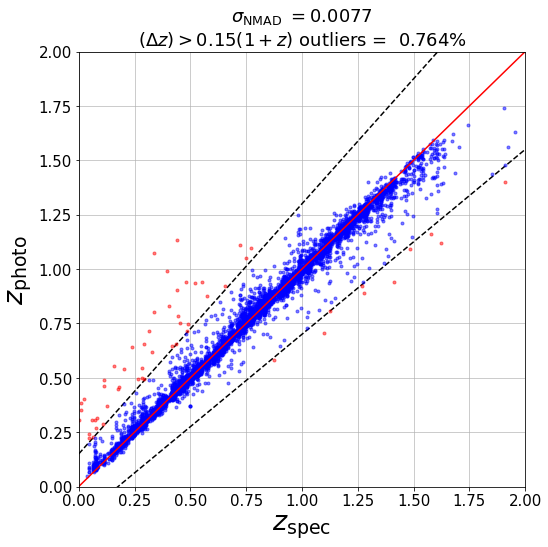

In [22]:
if 1:
    #First, let's see what happens in best case: training set = test set (no errors)
    regrn.fit(data_colmag,data_z)
    z_phot=regrn.predict(data_colmag)
    z_spec=data_z
    plot_and_stats(z_spec,z_phot)

Standard Deviation: 0.0684
Normalized MAD: 0.0190
Delta z >0.15(1+z) outliers:  3.749 percent
Median offset:  0.001 +/-  0.001


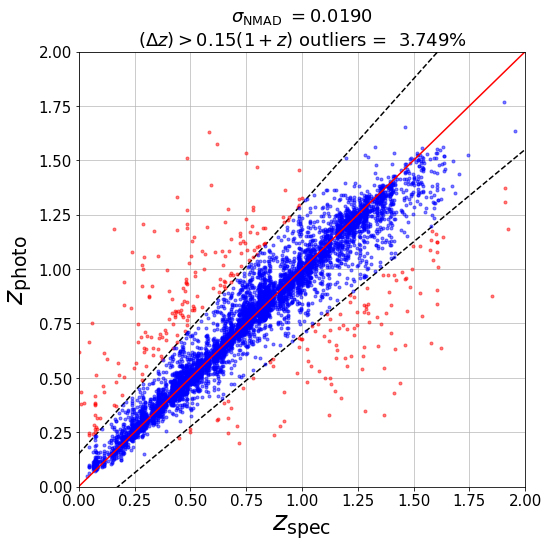

In [23]:
if 1:
    #Now, let's see when we add errors in this best case
    z_phot=regrn.predict(perturbed_colmag)
    z_spec=data_z
    plot_and_stats(z_spec,z_phot)

Standard Deviation: 0.0830
Normalized MAD: 0.0252
Delta z >0.15(1+z) outliers:  5.195 percent
Median offset:  0.000 +/-  0.002


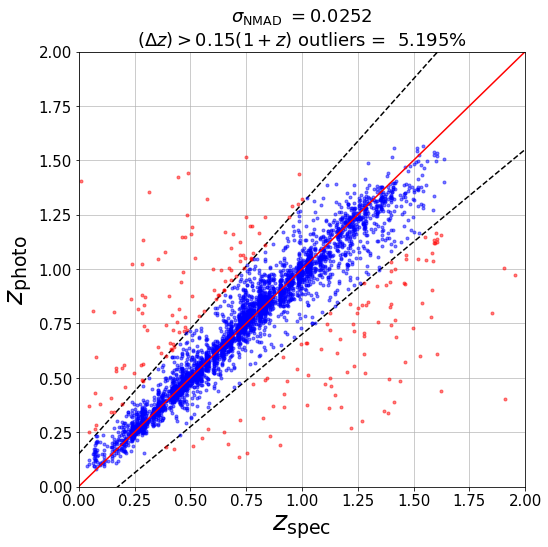

In [24]:
if 1:
    #Now, let's see how much things degrade when we divide training & test properly
    regrn.fit(data_train,z_train)
    z_phot=regrn.predict(perturbed_test)
    z_spec=pz_test
    plot_and_stats(z_spec,z_phot)

__Compare to our original results:__

    Standard Deviation: 0.0747
    Normalized MAD: 0.0220
    Delta z >0.15(1+z) outliers:  4.043 percent
    Median offset: -0.000 +/-  0.001

__Discuss: are our photo-z errors in this catalog dominated by measurement errors, or our training sets?__

# If you have extra time: 

1) Modify `plot_and_stats()` to make plots of ${z_{phot}-z_{zspec}} \over {1 + z_{spec}}$ as a function of redshift and as a function of $i$ magnitude.  Redo all plots.  What trends do you find in the residuals for each?

2) Look at the documentation for scikit-learn regression routines and try one or two other methods.  Can you do better than the random forest results?  There's a code box below you can work with.

3) Modify `plot_and_stats()` to provide the uncertainty in the standard deviation, not just the median shift, to help assess whether improvements are significant. $s (\sigma) = { \sigma \over \sqrt{2N}}$ where $\sigma$ is the standard deviation of the values, $s$ is the uncertainty in that standard deviation, and $N$ is the number of data points.